## Kaggle Digit Recognizer

In [13]:
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

from utils import *

In [83]:
train = pd.read_csv('kg-data/train.csv', sep=',')
train.shape

(42000, 785)

In [89]:
train = shuffle(train)

In [90]:
X = train.drop(labels=["label"], axis = 1)
Y = train["label"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)

X_train = X_train.values
Y_train = Y_train.values
Y_train_oh = pd.get_dummies(Y_train).values

X_test = X_test.values
Y_test = Y_test.values
Y_test_oh = pd.get_dummies(Y_test).values

print('train/test: %d/%d' % (len(X_train), len(X_test)))

# reshape

X_train_len = len(X_train)
X_train = X_train.reshape((X_train_len, 28, 28, 1))

X_test_len = len(X_test)
X_test = X_test.reshape((X_test_len, 28, 28, 1))

train/test: 37800/4200


## MNIST dataset

In [81]:
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.reshape((len(X_train), 28, 28, 1))
Y_train_oh = pd.get_dummies(Y_train).values
X_test = X_test.reshape((len(X_test), 28, 28, 1))
Y_test_oh = pd.get_dummies(Y_test).values

print('train/test: %d/%d' % (len(X_train), len(X_test)))

train/test: 60000/10000


## Model

In [4]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, AveragePooling2D, Dropout
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
def DigitRec_v1():
    pixel_values = Input(shape=(28, 28, 1, ), dtype='float32')
    X = Flatten()(pixel_values)
    X = Dense(20, activation='relu')(X)
    X = Dense(20, activation='relu')(X)
    X = Dense(10, activation='softmax')(X)
    model = Model(inputs=pixel_values, outputs=X)
    return model

In [5]:
def DigitRec_LeNet5():
    pixel_values = Input(shape=(28, 28, 1, ), dtype='float32')
    X = Conv2D(6, (5, 5), padding='same', activation='tanh')(pixel_values)
    X = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Conv2D(16, (5, 5), activation='tanh')(X)
    X = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Conv2D(120, (5, 5), activation='tanh')(X)
    X = Flatten()(X)
    X = Dense(84, activation='tanh')(X)
    X = Dropout(0.5)(X)
    X = Dense(10, activation='softmax')(X)
    model = Model(inputs=pixel_values, outputs=X)
    return model

In [38]:
del model

In [ ]:
model = DigitRec_LeNet5()
model.summary()

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train_oh, epochs=10, batch_size=64, shuffle=True)

In [82]:
loss, acc = model.evaluate(X_test, Y_test_oh)
print("Test accuracy = ", acc)

10000/10000 [==============================] - 1s 121us/step
Test accuracy =  0.9943


## Data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
datagen.fit(X_train)

In [ ]:
history = model.fit_generator(datagen.flow(X_train, Y_train_oh, batch_size=64), 
                              steps_per_epoch=len(X_train), epochs=30)

## Predictions

In [91]:
Y_pred_oh = model.predict(X_test)
Y_pred = np.array([np.argmax(i) for i in Y_pred_oh])

In [92]:
err_num = 0
err_idx = []
for idx in range(len(X_test)):
    if Y_test[idx] != Y_pred[idx]:
        err_num += 1
        err_idx.append(idx)
print('total errors: ' + str(err_num))

total errors: 16


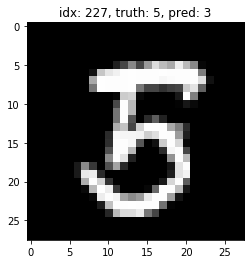

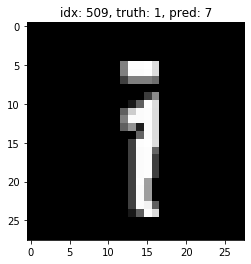

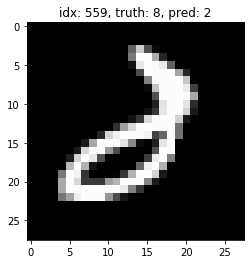

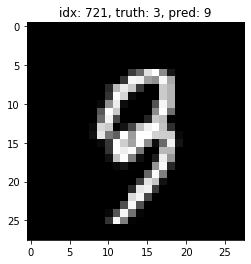

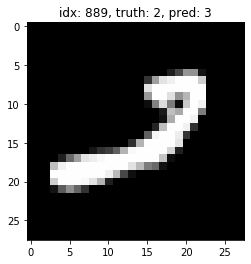

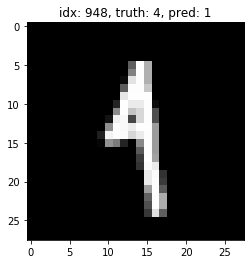

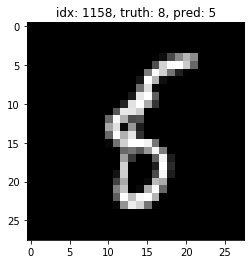

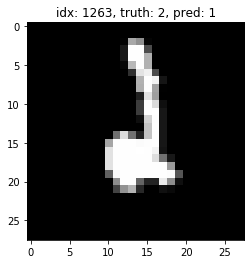

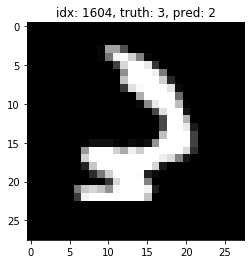

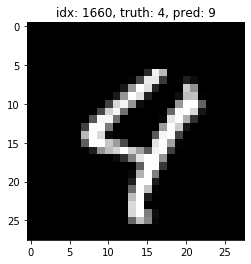

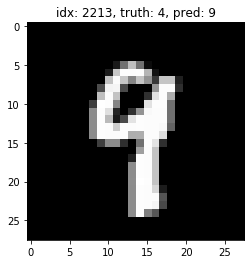

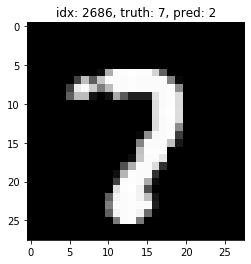

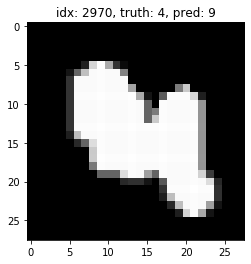

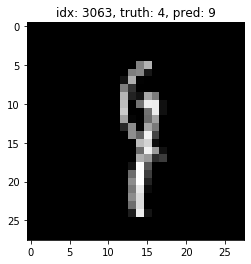

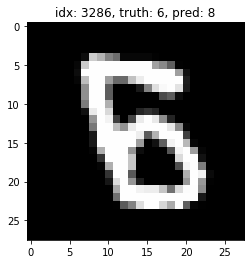

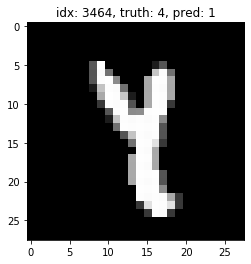

In [93]:
for idx in err_idx:
    pixels = X_test[idx].reshape((28, 28))
    plt.title('idx: %d, truth: %d, pred: %d' % (idx, Y_test[idx], Y_pred[idx]))
    plt.imshow(pixels, cmap=plt.cm.gray)
    plt.show()

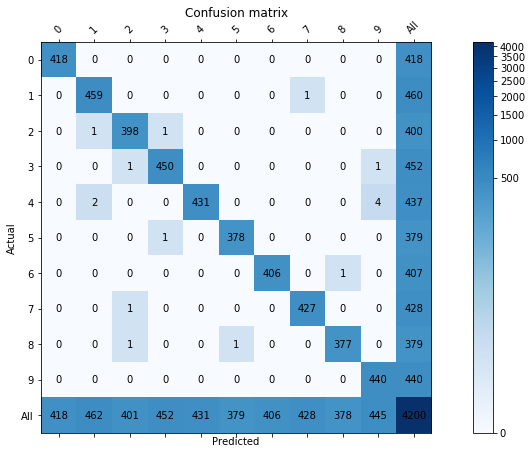

In [94]:
plot_confusion_matrix(Y_test, Y_pred, norm=False)

## Save/load models

In [ ]:
from keras.models import load_model

In [ ]:
model.save('kg_digit_rec.h5') 

In [56]:
del model

In [57]:
model = load_model('kg_digit_rec.h5')

## Submission

In [ ]:
sub_test = pd.read_csv('kg-data/test.csv', sep=',')
sub_test.shape

X_sub_test = sub_test.values
X_sub_test_len = len(X_sub_test)
X_sub_test = X_sub_test.reshape((X_sub_test_len, 28, 28, 1))

X_sub_test.shape

In [ ]:
Y_sub_pred_oh = model.predict(X_sub_test)
Y_sub_pred = np.array([np.argmax(i) for i in Y_sub_pred_oh])

In [ ]:
idx = np.random.randint(len(X_sub_test))
pixels = X_sub_test[idx].reshape((28, 28))
plt.title('idx: ' + str(idx) + ', predicted: ' + str(Y_sub_pred[idx]))
plt.imshow(pixels, cmap=plt.cm.gray)
plt.show()

In [ ]:
sub_pred_df = pd.DataFrame(columns=['ImageId', 'Label'])
for i in range(len(Y_sub_pred)):
    sub_pred_df.loc[i] = (i+1, Y_sub_pred[i])

In [ ]:
sub_pred_df.head()

In [ ]:
sub_pred_df.to_csv('kg-data/submission.csv', sep=',', index=False)

## Kaggle

In [ ]:
!kaggle competitions download -c digit-recognizer -p 'kg-data'

In [ ]:
!kaggle competitions submit -c digit-recognizer -f 'kg-data/submission.csv' -m ''